In [ ]:
#| hide
!pip install -Uqq nixtla utilsforecast

In [ ]:
#| hide 
from nixtla.utils import in_colab

In [ ]:
#| hide 
IN_COLAB = in_colab()

In [ ]:
#| hide
if not IN_COLAB:
    from nixtla.utils import colab_badge
    from dotenv import load_dotenv

# Fine-tuning with a specific loss function

When fine-tuning, the model trains on your dataset to tailor its predictions to your particular scenario. As such, it is possible to specify the loss function used during fine-tuning.\
\
Specifically, you can choose from:

* `"default"` - a proprietary loss function that is robust to outliers
* `"mae"` - mean absolute error
* `"mse"` - mean squared error
* `"rmse"` - root mean squared error
* `"mape"` - mean absolute percentage error
* `"smape"` - symmetric mean absolute percentage error

In [ ]:
#| echo: false
if not IN_COLAB:
    load_dotenv()    
    colab_badge('docs/tutorials/07_loss_function_finetuning')

[![](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Nixtla/nixtla/blob/main/nbs/docs/tutorials/07_loss_function_finetuning.ipynb)

## 1. Import packages
First, we import the required packages and initialize the Nixtla client.

In [ ]:
import pandas as pd
from nixtla import NixtlaClient
from utilsforecast.losses import mae, mse, rmse, mape, smape

In [ ]:
nixtla_client = NixtlaClient(
    # defaults to os.environ.get("NIXTLA_API_KEY")
    api_key = 'my_api_key_provided_by_nixtla'
)

> 👍 Use an Azure AI endpoint
> 
> To use an Azure AI endpoint, remember to set also the `base_url` argument:
> 
> `nixtla_client = NixtlaClient(
>         base_url="you azure ai endpoint",
>         api_key="your api_key"`
>)

In [ ]:
#| hide
if not IN_COLAB:
    nixtla_client = NixtlaClient()

## 2. Load data

Let's fine-tune the model on a dataset using the mean absolute error (MAE).\
\
For that, we simply pass the appropriate string representing the loss function to the `finetune_loss` parameter of the `forecast` method.

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/Nixtla/transfer-learning-time-series/main/datasets/air_passengers.csv')
df.insert(loc=0, column='unique_id', value=1)

df.head()

,unique_id,timestamp,value
0,1,1949-01-01,112
1,1,1949-02-01,118
2,1,1949-03-01,132
3,1,1949-04-01,129
4,1,1949-05-01,121


## 3. Fine-tuning with Mean Absolute Error

Let's fine-tune the model on a dataset using the Mean Absolute Error (MAE).\
\
For that, we simply pass the appropriate string representing the loss function to the `finetune_loss` parameter of the `forecast` method.

In [ ]:
timegpt_fcst_finetune_mae_df = nixtla_client.forecast(
    df=df, 
    h=12, 
    finetune_steps=10,
    finetune_loss='mae',   # Set your desired loss function
    time_col='timestamp', 
    target_col='value',
)

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Inferred freq: MS
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


> 📘 Available models in Azure AI
>
> If you are using an Azure AI endpoint, please be sure to set `model="azureai"`:
>
> `nixtla_client.forecast(..., model="azureai")`
> 
> For the public API, we support two models: `timegpt-1` and `timegpt-1-long-horizon`. 
> 
> By default, `timegpt-1` is used. Please see [this tutorial](https://docs.nixtla.io/docs/tutorials-long_horizon_forecasting) on how and when to use `timegpt-1-long-horizon`.

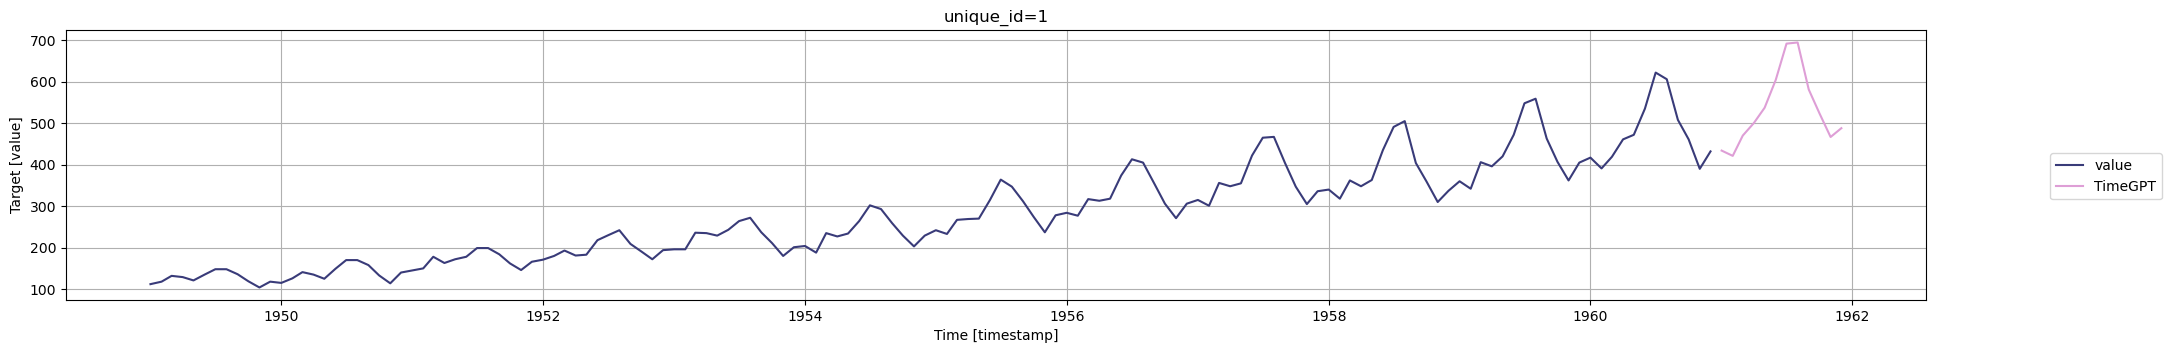

In [ ]:
nixtla_client.plot(
    df, timegpt_fcst_finetune_mae_df, 
    time_col='timestamp', target_col='value',
)

Now, depending on your data, you will use a specific error metric to accurately evaluate your forecasting model's performance.\
\
Below is a non-exhaustive guide on which metric to use depending on your use case.\
\
**Mean absolute error (MAE)**\
\
<img src="https://latex.codecogs.com/svg.image?\mathrm{MAE}(\mathbf{y}_{\tau}, \mathbf{\hat{y}}_{\tau}) = \frac{1}{H} \sum^{t+H}_{\tau=t+1} |y_{\tau} - \hat{y}_{\tau}|" />

- Robust to outliers
- Easy to understand
- You care equally about all error sizes
- Same units as your data

**Mean squared error (MSE)**\
\
<img src="https://latex.codecogs.com/svg.image?\mathrm{MSE}(\mathbf{y}_{\tau}, \mathbf{\hat{y}}_{\tau}) = \frac{1}{H} \sum^{t+H}_{\tau=t+1} (y_{\tau} - \hat{y}_{\tau})^{2}" />

- You want to penalize large errors more than small ones
- Sensitive to outliers
- Used when large errors must be avoided
- *Not* the same units as your data

**Root mean squared error (RMSE)**\
\
<img src="https://latex.codecogs.com/svg.image?\mathrm{RMSE}(\mathbf{y}_{\tau}, \mathbf{\hat{y}}_{\tau}) = \sqrt{\frac{1}{H} \sum^{t+H}_{\tau=t+1} (y_{\tau} - \hat{y}_{\tau})^{2}}" />

- Brings the MSE back to original units of data
- Penalizes large errors more than small ones

**Mean absolute percentage error (MAPE)**\
\
<img src="https://latex.codecogs.com/svg.image?\mathrm{MAPE}(\mathbf{y}_{\tau}, \mathbf{\hat{y}}_{\tau}) = \frac{1}{H} \sum^{t+H}_{\tau=t+1} \frac{|y_{\tau}-\hat{y}_{\tau}|}{|y_{\tau}|}" />

- Easy to understand for non-technical stakeholders
- Expressed as a percentage
- Heavier penalty on positive errors over negative errors
- To be avoided if your data has values close to 0 or equal to 0

**Symmmetric mean absolute percentage error (sMAPE)**\
\
<img src="https://latex.codecogs.com/svg.image?\mathrm{SMAPE}_{2}(\mathbf{y}_{\tau}, \mathbf{\hat{y}}_{\tau}) = \frac{1}{H} \sum^{t+H}_{\tau=t+1} \frac{|y_{\tau}-\hat{y}_{\tau}|}{|y_{\tau}|+|\hat{y}_{\tau}|}" />

- Fixes bias of MAPE
- Equally senstitive to over and under forecasting
- To be avoided if your data has values close to 0 or equal to 0

With TimeGPT, you can choose your loss function during fine-tuning as to maximize the model's performance metric for your particular use case.\
\
Let's run a small experiment to see how each loss function improves their associated metric when compared to the default setting.

In [ ]:
train = df[:-36]
test = df[-36:]

In [ ]:
losses = ['default', 'mae', 'mse', 'rmse', 'mape', 'smape']

test = test.copy()

for loss in losses:
    preds_df = nixtla_client.forecast(
    df=train, 
    h=36, 
    finetune_steps=10,
    finetune_loss=loss,
    time_col='timestamp', 
    target_col='value')

    preds = preds_df['TimeGPT'].values

    test.loc[:,f'TimeGPT_{loss}'] = preds

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Inferred freq: MS
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Inferred freq: MS
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Inferred freq: MS
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Inferred freq: MS
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Inferred freq: MS
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


> 📘 Available models in Azure AI
>
> If you are using an Azure AI endpoint, please be sure to set `model="azureai"`:
>
> `nixtla_client.forecast(..., model="azureai")`
> 
> For the public API, we support two models: `timegpt-1` and `timegpt-1-long-horizon`. 
> 
> By default, `timegpt-1` is used. Please see [this tutorial](https://docs.nixtla.io/docs/tutorials-long_horizon_forecasting) on how and when to use `timegpt-1-long-horizon`.

In [ ]:
#| hide
test.head()

,unique_id,timestamp,value,TimeGPT_default,TimeGPT_mae,TimeGPT_mse,TimeGPT_rmse,TimeGPT_mape,TimeGPT_smape
108,1,1958-01-01,340,347.134094,341.933563,347.600616,347.059113,356.154938,341.958679
109,1,1958-02-01,318,345.739746,343.268738,346.399963,345.678314,354.163422,343.929657
110,1,1958-03-01,362,394.611450,390.873169,395.436646,394.636627,396.496155,392.543640
111,1,1958-04-01,348,404.133545,400.997070,404.369598,403.498901,396.927185,402.459625
112,1,1958-05-01,363,421.236542,418.793365,422.122223,421.541443,410.335663,422.161255


Great! We have predictions from TimeGPT using all the different loss functions. We can evaluate the performance using their associated metric and measure the improvement.

In [ ]:
loss_fct_dict = {
    "mae": mae,
    "mse": mse,
    "rmse": rmse,
    "mape": mape,
    "smape": smape
}

pct_improv = []

for loss in losses[1:]:
    evaluation = loss_fct_dict[f'{loss}'](test, models=['TimeGPT_default', f'TimeGPT_{loss}'], id_col='unique_id', target_col='value')
    pct_diff = (evaluation['TimeGPT_default'] - evaluation[f'TimeGPT_{loss}']) / evaluation['TimeGPT_default'] * 100
    pct_improv.append(round(pct_diff, 2))

In [ ]:
data = {
    'mae': pct_improv[0].values,
    'mse': pct_improv[1].values,
    'rmse': pct_improv[2].values,
    'mape': pct_improv[3].values,
    'smape': pct_improv[4].values
}

metrics_df = pd.DataFrame(data)
metrics_df.index = ['Metric improvement (%)']

metrics_df

,mae,mse,rmse,mape,smape
Metric improvement (%),8.54,0.31,0.64,31.02,7.36


From the table above, we can see that using a specific loss function during fine-tuning will improve its associated error metric when compared to the default loss function.\
\
In this example, using the MAE as the loss function improves the metric by 8.54% when compared to using the default loss function.\
\
That way, depending on your use case and performance metric, you can use the appropriate loss function to maximize the accuracy of the forecasts.